In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

csv_files = [
    "/content/Petyr_Baelish.csv",
    "/content/Sam_Tarly.csv",
    "/content/Theon_Greyjoy.csv",
]

dfs = []
for f in csv_files:
    df = pd.read_csv(f)
    # set standard for character name
    df["Character"] = df["Name"].str.title()
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# save the raw that only reserve the topics and sentences
data = data.dropna(subset=["Sentence", "Unique Coding"])

print("数据行数：", len(data))
print("角色：", data["Character"].unique())
print("主题(Unique Coding)：", data["Unique Coding"].unique())

data = data.rename(columns={"Unique Coding": "Topic"})


# 1. Topic distribution per character 
topic_per_char = (
    data.groupby(["Character", "Topic"])
        .size()
        .reset_index(name="Count")
        .pivot(index="Character", columns="Topic", values="Count")
        .fillna(0)
        .astype(int)
)

print("\n=== Topic distribution per character (count of topics per character) ===")
print(topic_per_char)

# create new csv
topic_per_char.to_csv("topic_distribution_per_character.csv")

# 2. Global distribution 
global_topic_dist = (
    data["Topic"]
    .value_counts()
    .rename_axis("Topic")
    .reset_index(name="Count")
)

print("\n=== Global topic distribution (all characters) ===")
print(global_topic_dist)

global_topic_dist.to_csv("global_topic_distribution.csv", index=False)

# 3. Per-season per-character distribution 
per_season_char_topic = (
    data.groupby(["Season", "Character", "Topic"])
        .size()
        .reset_index(name="Count")
)

print("\n=== Per-season per-character topic counts (long format) ===")
print(per_season_char_topic.head())

# raw=Season+Character,colomn=Topic
per_season_char_pivot = per_season_char_topic.pivot_table(
    index=["Season", "Character"],
    columns="Topic",
    values="Count",
    fill_value=0,
    aggfunc="sum"
)

print("\n=== Per-season per-character topic pivot table ===")
print(per_season_char_pivot.head())

per_season_char_topic.to_csv("per_season_per_character_topic_counts.csv", index=False)
per_season_char_pivot.to_csv("per_season_per_character_topic_pivot.csv")

# 4. Global per-season topic distribution 
global_season_topic = (
    data.groupby(["Season", "Topic"])
        .size()
        .reset_index(name="Count")
)

print("\n=== Global per-season topic distribution ===")
print(global_season_topic.head())

global_season_topic.to_csv("global_per_season_topic_distribution.csv", index=False)

# 5. TF-IDF: 找出每个 Topic 内 tf-idf 最高的10个词
# 先把同一 Topic 的句子拼成一个文档
topic_docs = (
    data.groupby("Topic")["Sentence"]
        .apply(lambda s: " ".join(str(x) for x in s))
)

print("\n=== 每个 Topic 合并后的文档数 ===")
print(topic_docs.shape)

# create TF-IDF vector
vectorizer = TfidfVectorizer(
    stop_words="english",
    lowercase=True,
    max_df=0.8,
    min_df=1,
)

tfidf_matrix = vectorizer.fit_transform(topic_docs.values)
feature_names = np.array(vectorizer.get_feature_names_out())

topic_labels = topic_docs.index.tolist()
top_n = 10

rows = []
for i, topic in enumerate(topic_labels):
    row = tfidf_matrix[i].toarray().ravel()
    # from large to small
    top_indices = row.argsort()[::-1][:top_n]
    top_terms = feature_names[top_indices]
    top_scores = row[top_indices]
    for term, score in zip(top_terms, top_scores):
        rows.append({"Topic": topic, "Term": term, "TFIDF": float(score)})

top_terms_df = pd.DataFrame(rows)

print("\n=== Top 10 TF-IDF terms per Topic ===")
for topic in topic_labels:
    print(f"\n### Topic: {topic}")
    display(
        top_terms_df[top_terms_df["Topic"] == topic]
        .sort_values("TFIDF", ascending=False)
        .head(top_n)
    )

top_terms_df.to_csv("top_10_tfidf_terms_per_topic.csv", index=False)

数据行数： 1460
角色： ['Petyr Baelish' 'Sam Tarly' 'Theon Greyjoy']
主题(Unique Coding)： ['Politics' 'War/Violence' 'People' 'Plans/Strategy/Advice'
 'Information/Lore' 'Orders/Demands' 'Loyalty/Honour' 'Trivial']

=== Topic distribution per character (count of topics per character) ===
Topic          Information/Lore  Loyalty/Honour  Orders/Demands  People  \
Character                                                                 
Petyr Baelish                77              51              24      70   
Sam Tarly                   115              39              58     105   
Theon Greyjoy                95              68              69      47   

Topic          Plans/Strategy/Advice  Politics  Trivial  War/Violence  
Character                                                              
Petyr Baelish                    113        52       40            22  
Sam Tarly                         77        30       92            40  
Theon Greyjoy                     47        35       38  

,Topic,Term,TFIDF
0,Information/Lore,wall,0.142306
1,Information/Lore,night,0.139368
2,Information/Lore,citadel,0.128352
3,Information/Lore,high,0.127493
4,Information/Lore,escape,0.126771
5,Information/Lore,saw,0.114028
6,Information/Lore,took,0.112536
7,Information/Lore,dragonglass,0.106244
8,Information/Lore,ice,0.101417
9,Information/Lore,wanted,0.099614



### Topic: Loyalty/Honour


,Topic,Term,TFIDF
10,Loyalty/Honour,serve,0.174576
11,Loyalty/Honour,promise,0.168591
12,Loyalty/Honour,save,0.168591
13,Loyalty/Honour,help,0.135489
14,Loyalty/Honour,defend,0.134873
15,Loyalty/Honour,honor,0.134873
16,Loyalty/Honour,queen,0.127554
17,Loyalty/Honour,yara,0.127554
18,Loyalty/Honour,gave,0.127554
19,Loyalty/Honour,failed,0.120698



### Topic: Orders/Demands


,Topic,Term,TFIDF
20,Orders/Demands,stop,0.243391
21,Orders/Demands,inside,0.183826
22,Orders/Demands,mercy,0.164506
23,Orders/Demands,leave,0.153888
24,Orders/Demands,safe,0.139080
25,Orders/Demands,wait,0.139080
26,Orders/Demands,hear,0.137009
27,Orders/Demands,alright,0.118970
28,Orders/Demands,olly,0.118970
29,Orders/Demands,pyp,0.118970



### Topic: People


,Topic,Term,TFIDF
30,People,reek,0.491800
31,People,beautiful,0.207073
32,People,theon,0.160710
33,People,archmaester,0.155305
34,People,petyr,0.143166
35,People,arryn,0.129421
36,People,thing,0.125198
37,People,children,0.113474
38,People,warrior,0.107375
39,People,brienne,0.107375



### Topic: Plans/Strategy/Advice


,Topic,Term,TFIDF
40,Plans/Strategy/Advice,make,0.211564
41,Plans/Strategy/Advice,north,0.186674
42,Plans/Strategy/Advice,safe,0.157913
43,Plans/Strategy/Advice,return,0.149426
44,Plans/Strategy/Advice,help,0.125802
45,Plans/Strategy/Advice,try,0.111824
46,Plans/Strategy/Advice,fight,0.108063
47,Plans/Strategy/Advice,happy,0.104359
48,Plans/Strategy/Advice,need,0.099559
49,Plans/Strategy/Advice,black,0.099559



### Topic: Politics


,Topic,Term,TFIDF
50,Politics,grace,0.396038
51,Politics,queen,0.279633
52,Politics,aegon,0.176402
53,Politics,realm,0.139817
54,Politics,single,0.132302
55,Politics,marrying,0.132302
56,Politics,north,0.132225
57,Politics,heir,0.127573
58,Politics,tywin,0.127573
59,Politics,crown,0.127573



### Topic: Trivial


,Topic,Term,TFIDF
60,Trivial,walks,0.250289
61,Trivial,turns,0.167809
62,Trivial,work,0.167809
63,Trivial,sam,0.158703
64,Trivial,knife,0.150173
65,Trivial,jr,0.150173
66,Trivial,library,0.144805
67,Trivial,looks,0.144805
68,Trivial,door,0.125857
69,Trivial,boat,0.125857



### Topic: War/Violence


,Topic,Term,TFIDF
70,War/Violence,kill,0.341430
71,War/Violence,killed,0.297787
72,War/Violence,walker,0.190046
73,War/Violence,white,0.160673
74,War/Violence,killing,0.132728
75,War/Violence,throat,0.114533
76,War/Violence,war,0.114533
77,War/Violence,gregor,0.106182
78,War/Violence,took,0.100420
79,War/Violence,hound,0.095023


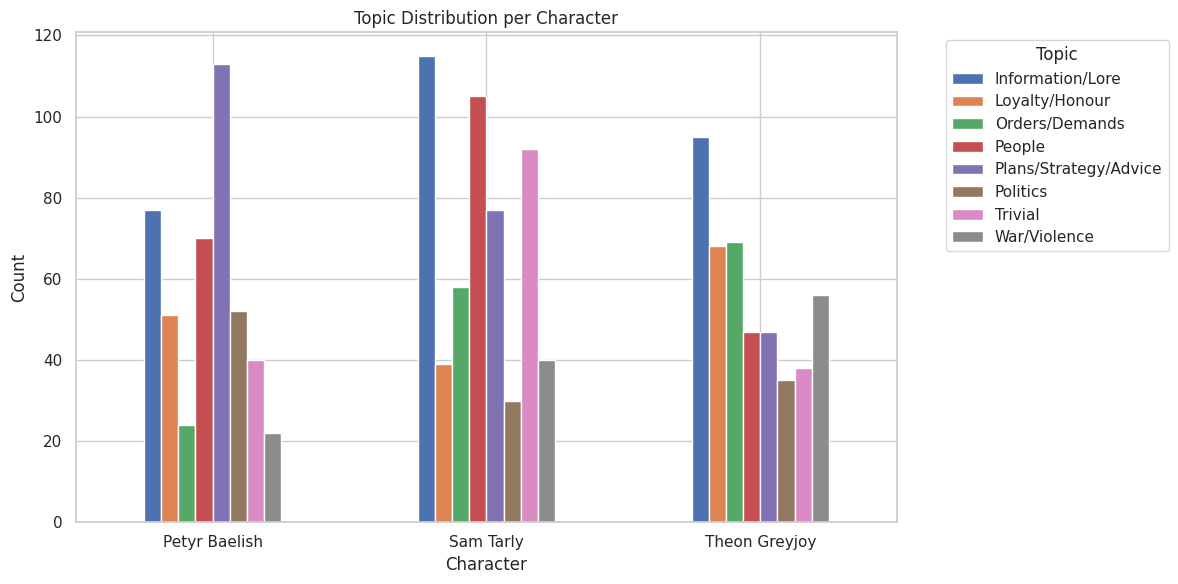

/tmp/ipython-input-3781834512.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_topic_dist, x="Topic", y="Count", palette="tab10")


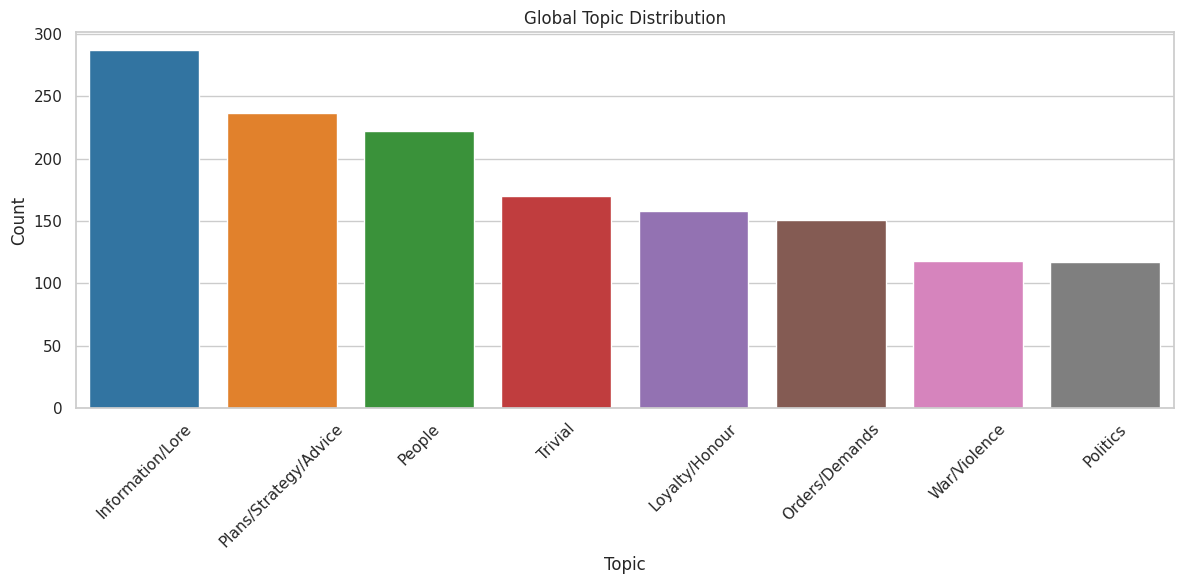

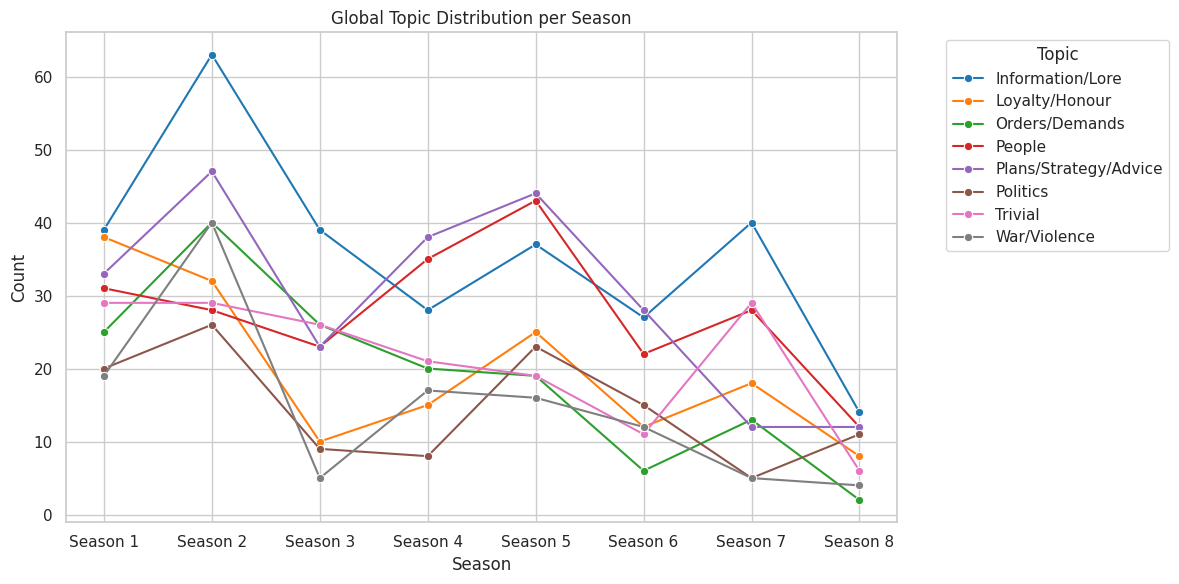

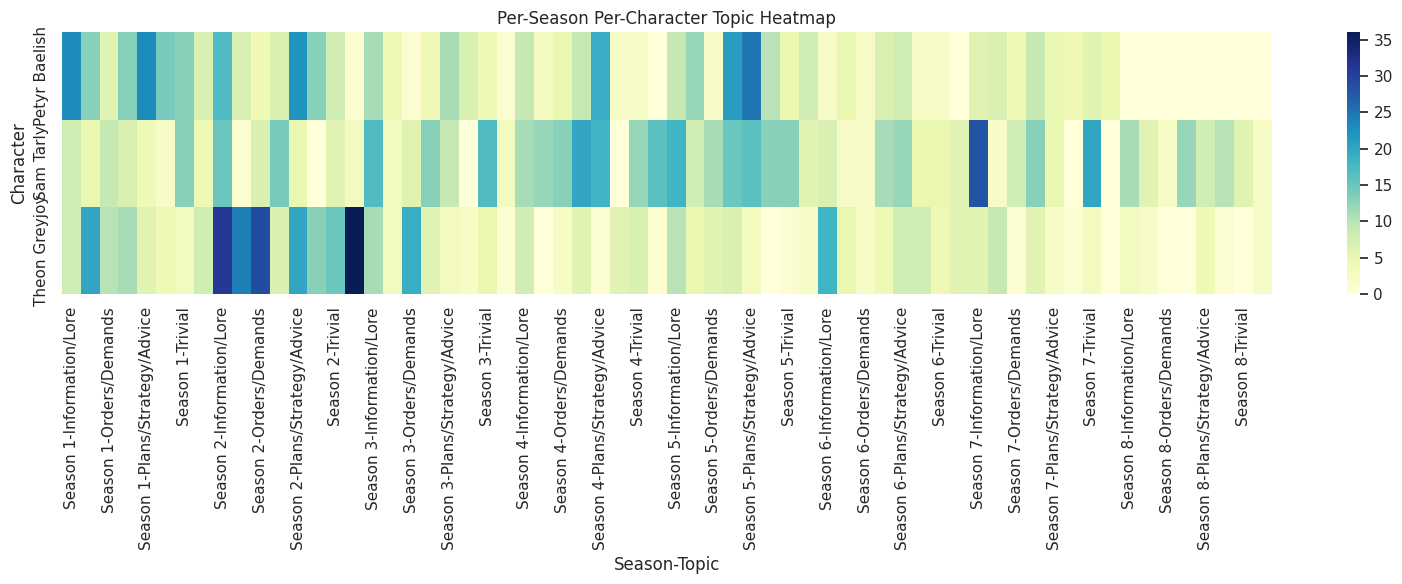

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Topic Distribution per Character
topic_per_char_plot = topic_per_char.copy()
topic_per_char_plot.plot(kind="bar", stacked=False)

plt.title("Topic Distribution per Character")
plt.xlabel("Character")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Global Topic Distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=global_topic_dist, x="Topic", y="Count", palette="tab10")

plt.title("Global Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Global Topic Distribution per Season 
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=global_season_topic,
    x="Season",
    y="Count",
    hue="Topic",
    marker="o",
    palette="tab10"
)

plt.title("Global Topic Distribution per Season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Per-Season Per-Character Topic Heatmap 
pivot_heat = per_season_char_topic.pivot_table(
    index="Character",
    columns=["Season", "Topic"],
    values="Count",
    fill_value=0
)

plt.figure(figsize=(16, 6))
sns.heatmap(pivot_heat, cmap="YlGnBu")
plt.title("Per-Season Per-Character Topic Heatmap")
plt.tight_layout()
plt.show()
